# Toybox-12 50 epochs

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/ug-project/src")
!pwd
%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/ug-project/src


In [4]:
import numpy as np
import torchvision.transforms.v2 as v2
from datasets import ToyboxDataset, TOYBOX_MEAN, TOYBOX_STD
from torch.utils.data import DataLoader

### Set hyperparameters

In [5]:
learning_rate = 0.01
epochs = 100
batch_size = 256
output_dir_clear = "/content/drive/MyDrive/ug-project/output/alexnet/toybox12_clear_100_epochs"
output_dir_blur = "/content/drive/MyDrive/ug-project/output/alexnet/toybox12_blurry_to_clear_100_epochs"

os.makedirs(output_dir_clear, exist_ok=True)
os.makedirs(output_dir_blur, exist_ok=True)

### Define transforms

In [6]:
rng = np.random.default_rng(seed=5)

prob = 0.2
color_transforms = [v2.RandomApply([v2.ColorJitter(brightness=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(hue=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(saturation=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(contrast=0.2)], p=prob),
                    v2.RandomEqualize(p=prob),
                    v2.RandomPosterize(bits=4, p=prob),
                    v2.RandomAutocontrast(p=prob)
                    ]
transform = v2.Compose([v2.ToPILImage(),
                        v2.Resize((256, 256)),
                        v2.RandomResizedCrop(size=224, scale=(0.5, 1.0), interpolation=v2.InterpolationMode.BICUBIC),
                        v2.RandomOrder(color_transforms),
                        v2.RandomHorizontalFlip(),
                        v2.ToTensor(),
                        v2.Normalize(mean=TOYBOX_MEAN, std=TOYBOX_STD),
                        v2.RandomErasing(p=0.5)
                        ])
transform_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(224),
    v2.ToTensor(),
    v2.Normalize(mean=TOYBOX_MEAN, std=TOYBOX_STD)
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Load Toybox 12 dataset

In [7]:
train_dataset = ToyboxDataset(rng=rng, train=True, hypertune=True, transform=transform, num_images_per_class=3000)
print(f"Train set size: {len(train_dataset)}")

val_dataset = ToyboxDataset(rng=rng, train=False, hypertune=True, transform=transform_test)
print(f"Val set size: {len(val_dataset)}")

test_dataset = ToyboxDataset(rng=rng, train=False, hypertune=False, transform=transform_test)
print(f"Test set size: {len(test_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

Train set size: 36000
Val set size: 13299
Test set size: 13518


### Create AlexNet model

In [ ]:
import torch
import torch.nn as nn
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clear_model = AlexNetSup(num_classes=12).to(device)
blur_model = AlexNetSup(num_classes=12).to(device)
full_blur_model = AlexNetSup(num_classes=12).to(device)

criterion = nn.CrossEntropyLoss()

clear_optimizer = torch.optim.Adam(clear_model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=0.0001)
blur_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=0.0001)
full_blur_optimizer = torch.optim.Adam(full_blur_model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=0.0001)

steps = len(train_loader)

# Learning rate scheduler for clear model
clear_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=clear_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
clear_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=clear_optimizer, T_max=(epochs - 2) * steps)
clear_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=clear_optimizer,
                                                            schedulers=[clear_warmup_scheduler, clear_decay_scheduler],
                                                            milestones=[2*steps+1])

# Learning rate scheduler for blurry-to-clear model
blur_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=blur_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
blur_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=blur_optimizer, T_max=(epochs - 2) * steps)
blur_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=blur_optimizer,
                                                            schedulers=[blur_warmup_scheduler, blur_decay_scheduler],
                                                            milestones=[2*steps+1])

### Evaluate model before training

In [ ]:
!pip install kornia

In [ ]:
from utils import add_blur_with

# Initialize metrics for plotting
clear_train_correct, clear_val_correct = [], []
blur_train_correct, blur_val_correct = [], []
clear_train_loss_list, clear_val_loss_list = [], []
blur_train_loss_list, blur_val_loss_list = [], []
logs_clear = []
logs_blur = []

clear_model.eval()
blur_model.eval()

# Training metrics initialization
clear_train_corr, blur_train_corr, total_train = 0, 0, 0
clear_train_loss, blur_train_loss = 0.0, 0.0

with torch.no_grad():
    for _, images, labels in train_loader:
        # Apply blur transformation
        blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)
        blurred_images = blurred_images.to(device)

        # Get predictions from both models
        clear_y_pred = clear_model(images)
        blur_y_pred = blur_model(blurred_images)

        # Calculate loss values
        clear_loss = criterion(clear_y_pred, labels)
        blur_loss = criterion(blur_y_pred, labels)

        # Accumulate total loss weighted by batch size
        clear_train_loss += clear_loss.item() * labels.size(0)
        blur_train_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        clear_predicted = torch.max(clear_y_pred.data, 1)[1]
        blur_predicted = torch.max(blur_y_pred.data, 1)[1]
        clear_train_corr += (clear_predicted == labels).sum().item()
        blur_train_corr += (blur_predicted == labels).sum().item()
        total_train += labels.size(0)

# Average accuracy and loss over all training samples
clear_train_accuracy = (clear_train_corr / total_train) * 100
blur_train_accuracy = (blur_train_corr / total_train) * 100
clear_train_loss /= total_train
blur_train_loss /= total_train

# Validation metrics initialization
clear_val_corr, blur_val_corr, total_val = 0, 0, 0
clear_val_loss, blur_val_loss = 0.0, 0.0

with torch.no_grad():
    for _, images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Get predictions from both models on validation data
        clear_y_val_pred = clear_model(images)
        blur_y_val_pred = blur_model(images)

        # Calculate loss values for validation set
        clear_loss = criterion(clear_y_val_pred, labels)
        blur_loss = criterion(blur_y_val_pred, labels)

        # Accumulate total loss weighted by batch size
        clear_val_loss += clear_loss.item() * labels.size(0)
        blur_val_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        clear_predicted = torch.max(clear_y_val_pred.data, 1)[1]
        blur_predicted = torch.max(blur_y_val_pred.data, 1)[1]
        clear_val_corr += (clear_predicted == labels).sum().item()
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

# Average accuracy and loss over all validation samples
clear_val_accuracy = (clear_val_corr / total_val) * 100
blur_val_accuracy = (blur_val_corr / total_val) * 100
clear_val_loss /= total_val
blur_val_loss /= total_val

# Save results for plotting
clear_train_correct.append(clear_train_accuracy)
clear_val_correct.append(clear_val_accuracy)
blur_train_correct.append(blur_train_accuracy)
blur_val_correct.append(blur_val_accuracy)
clear_train_loss_list.append(clear_train_loss)
blur_train_loss_list.append(blur_train_loss)
clear_val_loss_list.append(clear_val_loss)
blur_val_loss_list.append(blur_val_loss)

# Log entry with both accuracy and loss values
clear_log_entry = (f"Epoch 0/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss:.4f}")
print(clear_log_entry)
logs_clear.append(clear_log_entry)

blur_log_entry = (f"Epoch 0/{epochs}, Blur train acc: {blur_train_accuracy:.4f}%, Blur train loss: {blur_train_loss:.4f}, Blur val acc: {blur_val_accuracy:.2f}%, Blur val loss: {blur_val_loss:.4f}")
print(blur_log_entry)
logs_blur.append(blur_log_entry)

Epoch 0/50, Clear train acc: 8.4291%, Clear train loss: 2.4898, Clear val acc: 10.00%, Clear val loss: 2.4900
Epoch 0/50, Blurry-to-clear train acc: 7.8265%, Blurry-to-clear train loss: 2.4933, Blurry-to-clear val acc: 8.56%, Blurry-to-clear val loss: 2.4934
Epoch 0/50, Blur train acc: 8.0385%, Blur train loss: 2.4884, Blur val acc: 6.20%, Blur val loss: 2.4907


### Training loop

In [ ]:
for epoch in range(0, epochs):

    ###################### Train model #########################
    clear_model.train()
    blur_model.train()

    # Initialize accumulators for training loss and sample count
    clear_train_loss_sum, blur_train_loss_sum = 0.0, 0.0
    train_samples = 0

    for _, images, labels in train_loader:

        # Apply blur sigma depending on training stage
        if epoch < 20:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        elif epoch < 40:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
        elif epoch < 60:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
        elif epoch < 80:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
        else:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])

        blurred_images, labels = blurred_images.to(device), labels.to(device)
        images = images.to(device)

        # Zero the parameter gradients
        clear_optimizer.zero_grad()
        blur_optimizer.zero_grad()
        full_blur_optimizer.zero_grad()

        # Forward passes
        clear_logits = clear_model(images)
        blur_logits = blur_model(blurred_images)

        # Compute losses
        clear_loss = criterion(clear_logits, labels)
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        clear_loss.backward()
        blur_loss.backward()
        clear_optimizer.step()
        blur_optimizer.step()
        #clear_scheduler.step()
        #blur_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        clear_train_loss_sum += clear_loss.item() * batch_size
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    clear_train_loss_epoch = clear_train_loss_sum / train_samples
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    clear_model.eval()
    blur_model.eval()
    clear_train_corr, blur_train_corr, total_train = 0, 0, 0
    clear_train_loss_eval, blur_train_loss_eval = 0.0, 0.0

    with torch.no_grad():
        for _, images, labels in train_loader:
            if epoch < 20:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            elif epoch < 440:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
            elif epoch < 60:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
            elif epoch < 80:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
            else:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])

            blurred_images, labels = blurred_images.to(device), labels.to(device)
            images = images.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(blurred_images)

            # Calculate loss on the training set (evaluation mode)
            clear_loss_eval = criterion(clear_y_pred, labels)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            clear_train_loss_eval += clear_loss_eval.item() * batch_size
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_train_corr += (clear_predicted == labels).sum().item()
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    clear_train_accuracy = (clear_train_corr / total_train) * 100
    blur_train_accuracy = (blur_train_corr / total_train) * 100
    clear_train_loss_avg = clear_train_loss_eval / total_train
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    clear_val_corr, blur_val_corr, total_val = 0, 0, 0
    clear_val_loss_sum, blur_val_loss_sum = 0.0, 0.0

    with torch.no_grad():
        for _, images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(images)

            # Compute validation losses
            clear_loss_val = criterion(clear_y_pred, labels)
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            clear_val_loss_sum += clear_loss_val.item() * batch_size
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_val_corr += (clear_predicted == labels).sum().item()
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    clear_val_accuracy = (clear_val_corr / total_val) * 100
    blur_val_accuracy = (blur_val_corr / total_val) * 100
    clear_val_loss_avg = clear_val_loss_sum / total_val
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    clear_train_loss_list.append(clear_train_loss_avg)
    blur_train_loss_list.append(blur_train_loss_avg)
    clear_val_loss_list.append(clear_val_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    clear_train_correct.append(clear_train_accuracy)
    clear_val_correct.append(clear_val_accuracy)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    clear_log_entry = (f"Epoch {epoch+1}/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss_avg:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss_avg:.4f}")
    print(clear_log_entry)
    logs_clear.append(clear_log_entry)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Blur train acc: {blur_train_accuracy:.4f}%, Blur train loss: {blur_train_loss_avg:.4f}, Blur val acc: {blur_val_accuracy:.2f}%, Blur val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs_blur.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        clear_checkpoint_path = os.path.join(output_dir_clear, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_clear = {
            'epoch': epoch+1,
            'model_state_dict': clear_model.state_dict(),
            'optimizer_state_dict': clear_optimizer.state_dict(),
            'train_accuracy': clear_train_accuracy,
            'train_loss': clear_train_loss_epoch,
        }
        torch.save(checkpoint_clear, clear_checkpoint_path)

        blur_checkpoint_path = os.path.join(output_dir_blur, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 1/50, Clear train acc: 38.6133%, Clear train loss: 1.8227, Clear val acc: 36.67%, Clear val loss: 1.8654
Epoch 1/50, Blur train acc: 31.6602%, Blur train loss: 2.0296, Blur val acc: 25.35%, Blur val loss: 2.2818
Epoch 2/50, Clear train acc: 49.9693%, Clear train loss: 1.5035, Clear val acc: 44.13%, Clear val loss: 1.7098
Epoch 2/50, Blur train acc: 40.5218%, Blur train loss: 1.7500, Blur val acc: 29.30%, Blur val loss: 2.3125
Epoch 3/50, Clear train acc: 54.2494%, Clear train loss: 1.3644, Clear val acc: 46.52%, Clear val loss: 1.6859
Epoch 3/50, Blur train acc: 45.3795%, Blur train loss: 1.6204, Blur val acc: 34.91%, Blur val loss: 2.2106
Epoch 4/50, Clear train acc: 56.9531%, Clear train loss: 1.2576, Clear val acc: 48.61%, Clear val loss: 1.6287
Epoch 4/50, Blur train acc: 48.4682%, Blur train loss: 1.5309, Blur val acc: 30.68%, Blur val loss: 2.4842
Epoch 5/50, Clear train acc: 62.9743%, Clear train loss: 1.1116, Clear val acc: 49.26%, Clear val loss: 1.6586
Epoch 5/50, Blur 

### Save logs to a txt file

In [ ]:
import pickle

with open(f"{output_dir_clear}/training_log.txt", 'w') as log_file:
    for log_entry in logs_clear:
        log_file.write(log_entry + '\n')

with open(f"{output_dir_blur}/training_log.txt", 'w') as log_file:
    for log_entry in logs_blur:
        log_file.write(log_entry + '\n')

clear_metrics = {
    'clear_train_correct': clear_train_correct,
    'clear_val_correct': clear_val_correct,
    'clear_train_loss_list': clear_train_loss_list,
    'clear_val_loss_list': clear_val_loss_list
}
blur_metrics = {
    'blur_train_correct': blur_train_correct,
    'blur_val_correct': blur_val_correct,
    'blur_train_loss_list': blur_train_loss_list,
    'blur_val_loss_list': blur_val_loss_list
}

with open(f"{output_dir_clear}/metrics.pkl", "wb") as clear_metrics_file:
    pickle.dump(clear_metrics, clear_metrics_file)

with open(f"{output_dir_blur}/metrics.pkl", "wb") as blur_metrics_file:
    pickle.dump(blur_metrics, blur_metrics_file)

### Plot clear loss and accuracy

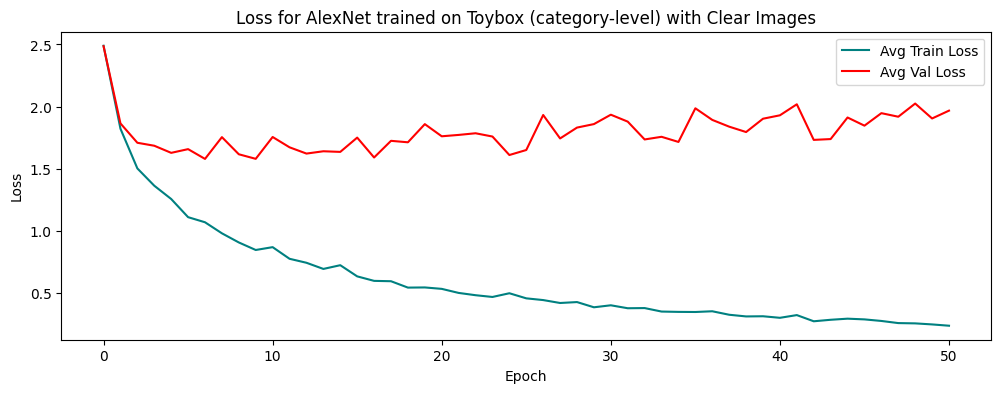

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(clear_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(clear_val_loss_list, color='red', label='Avg Val Loss')
plt.title(f'Loss for AlexNet trained on Toybox (category-level) with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

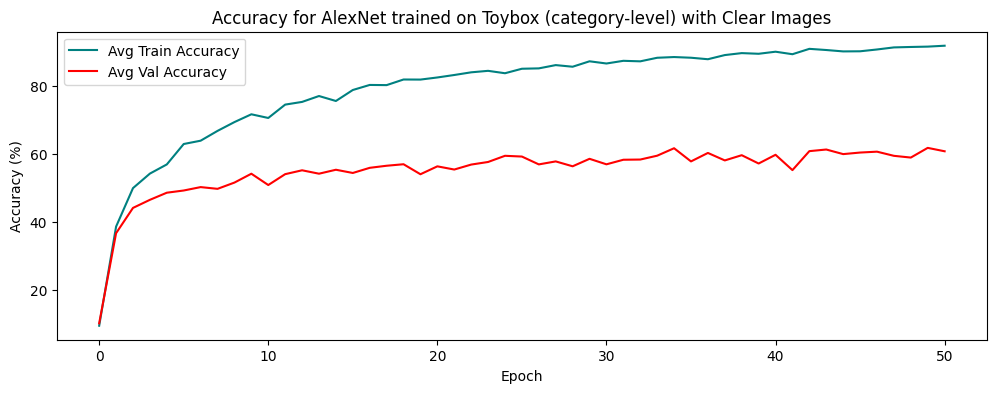

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(clear_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(clear_val_correct, color='red', label='Avg Val Accuracy')
plt.title(f'Accuracy for AlexNet trained on Toybox (category-level) with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Plot blurry-to-clear loss and accuracy

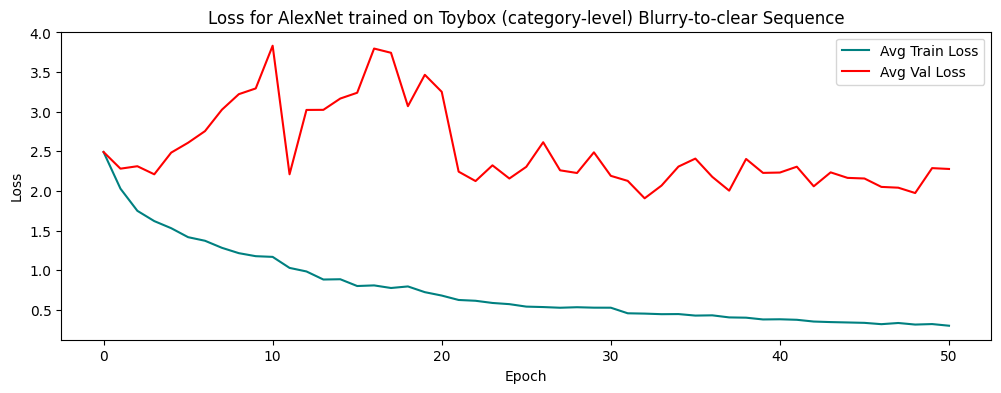

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
plt.title(f'Loss for AlexNet trained on Toybox (category-level) Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

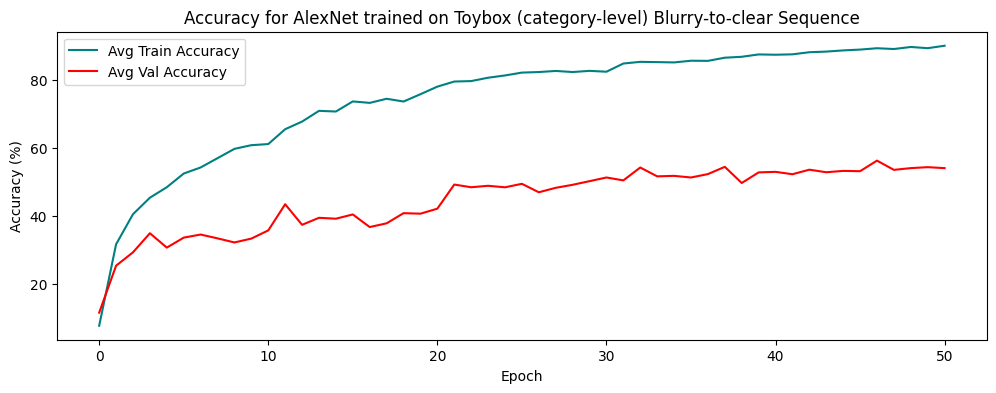

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Val Accuracy')
plt.title(f'Accuracy for AlexNet trained on Toybox (category-level) Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Toybox-12 100 epoch training

In [ ]:
import os
os.chdir("/content/drive/MyDrive/ug-project/src")
!pwd
%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/ug-project/src


In [ ]:
import numpy as np
import torchvision.transforms.v2 as v2
from datasets import ToyboxDataset, TOYBOX_MEAN, TOYBOX_STD
from torch.utils.data import DataLoader

### Set hyperparameters

In [8]:
learning_rate = 0.01
epochs = 100
batch_size = 256
output_dir_clear = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_clear_100_epochs"
output_dir_blur = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_blurry_to_clear_100_epochs"

os.makedirs(output_dir_clear, exist_ok=True)
os.makedirs(output_dir_blur, exist_ok=True)

### Define transforms

In [9]:
rng = np.random.default_rng(seed=5)

prob = 0.2
color_transforms = [v2.RandomApply([v2.ColorJitter(brightness=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(hue=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(saturation=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(contrast=0.2)], p=prob),
                    v2.RandomEqualize(p=prob),
                    v2.RandomPosterize(bits=4, p=prob),
                    v2.RandomAutocontrast(p=prob)
                    ]
transform = v2.Compose([v2.ToPILImage(),
                        v2.Resize((256, 256)),
                        v2.RandomResizedCrop(size=224, scale=(0.5, 1.0), interpolation=v2.InterpolationMode.BICUBIC),
                        v2.RandomOrder(color_transforms),
                        v2.RandomHorizontalFlip(),
                        v2.ToTensor(),
                        v2.Normalize(mean=TOYBOX_MEAN, std=TOYBOX_STD),
                        v2.RandomErasing(p=0.5)
                        ])
transform_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(224),
    v2.ToTensor(),
    v2.Normalize(mean=TOYBOX_MEAN, std=TOYBOX_STD)
])

### Load Toybox 12 dataset

In [10]:
train_dataset = ToyboxDataset(rng=rng, train=True, hypertune=True, transform=transform, num_images_per_class=3000)
print(f"Train set size: {len(train_dataset)}")

val_dataset = ToyboxDataset(rng=rng, train=False, hypertune=True, transform=transform_test)
print(f"Val set size: {len(val_dataset)}")

test_dataset = ToyboxDataset(rng=rng, train=False, hypertune=False, transform=transform_test)
print(f"Test set size: {len(test_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

Train set size: 36000
Val set size: 13299
Test set size: 13518


### Create AlexNet model

In [11]:
import torch
import torch.nn as nn
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clear_model = AlexNetSup(num_classes=12).to(device)
blur_model = AlexNetSup(num_classes=12).to(device)

criterion = nn.CrossEntropyLoss()

clear_optimizer = torch.optim.Adam(clear_model.parameters(), lr=learning_rate, weight_decay=0.0001)
blur_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, weight_decay=0.0001)

steps = len(train_loader)

# Learning rate scheduler for clear model
clear_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=clear_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
clear_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=clear_optimizer, T_max=(epochs - 2) * steps)
clear_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=clear_optimizer,
                                                            schedulers=[clear_warmup_scheduler, clear_decay_scheduler],
                                                            milestones=[2*steps+1])

# Learning rate scheduler for blurry-to-clear model
blur_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=blur_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
blur_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=blur_optimizer, T_max=(epochs - 2) * steps)
blur_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=blur_optimizer,
                                                            schedulers=[blur_warmup_scheduler, blur_decay_scheduler],
                                                            milestones=[2*steps+1])

### Evaluate model before training

In [ ]:
!pip install kornia

In [ ]:
from utils import add_blur_with

# Initialize metrics for plotting
clear_train_correct, clear_val_correct = [], []
blur_train_correct, blur_val_correct = [], []
clear_train_loss_list, clear_val_loss_list = [], []
blur_train_loss_list, blur_val_loss_list = [], []
logs_clear = []
logs_blur = []

clear_model.eval()
blur_model.eval()

# Training metrics initialization
clear_train_corr, blur_train_corr, total_train = 0, 0, 0
clear_train_loss, blur_train_loss = 0.0, 0.0

with torch.no_grad():
    for _, images, labels in train_loader:
        # Apply blur transformation
        blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)
        blurred_images = blurred_images.to(device)

        # Get predictions from both models
        clear_y_pred = clear_model(images)
        blur_y_pred = blur_model(blurred_images)

        # Calculate loss values
        clear_loss = criterion(clear_y_pred, labels)
        blur_loss = criterion(blur_y_pred, labels)

        # Accumulate total loss weighted by batch size
        clear_train_loss += clear_loss.item() * labels.size(0)
        blur_train_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        clear_predicted = torch.max(clear_y_pred.data, 1)[1]
        blur_predicted = torch.max(blur_y_pred.data, 1)[1]
        clear_train_corr += (clear_predicted == labels).sum().item()
        blur_train_corr += (blur_predicted == labels).sum().item()
        total_train += labels.size(0)

# Average accuracy and loss over all training samples
clear_train_accuracy = (clear_train_corr / total_train) * 100
blur_train_accuracy = (blur_train_corr / total_train) * 100
clear_train_loss /= total_train
blur_train_loss /= total_train

# Validation metrics initialization
clear_val_corr, blur_val_corr, total_val = 0, 0, 0
clear_val_loss, blur_val_loss = 0.0, 0.0

with torch.no_grad():
    for _, images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Get predictions from both models on validation data
        clear_y_val_pred = clear_model(images)
        blur_y_val_pred = blur_model(images)

        # Calculate loss values for validation set
        clear_loss = criterion(clear_y_val_pred, labels)
        blur_loss = criterion(blur_y_val_pred, labels)

        # Accumulate total loss weighted by batch size
        clear_val_loss += clear_loss.item() * labels.size(0)
        blur_val_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        clear_predicted = torch.max(clear_y_val_pred.data, 1)[1]
        blur_predicted = torch.max(blur_y_val_pred.data, 1)[1]
        clear_val_corr += (clear_predicted == labels).sum().item()
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

# Average accuracy and loss over all validation samples
clear_val_accuracy = (clear_val_corr / total_val) * 100
blur_val_accuracy = (blur_val_corr / total_val) * 100
clear_val_loss /= total_val
blur_val_loss /= total_val

# Save results for plotting
clear_train_correct.append(clear_train_accuracy)
clear_val_correct.append(clear_val_accuracy)
blur_train_correct.append(blur_train_accuracy)
blur_val_correct.append(blur_val_accuracy)
clear_train_loss_list.append(clear_train_loss)
blur_train_loss_list.append(blur_train_loss)
clear_val_loss_list.append(clear_val_loss)
blur_val_loss_list.append(blur_val_loss)

# Log entry with both accuracy and loss values
clear_log_entry = (f"Epoch 0/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss:.4f}")
print(clear_log_entry)
logs_clear.append(clear_log_entry)

blur_log_entry = (f"Epoch 0/{epochs}, Blur train acc: {blur_train_accuracy:.4f}%, Blur train loss: {blur_train_loss:.4f}, Blur val acc: {blur_val_accuracy:.2f}%, Blur val loss: {blur_val_loss:.4f}")
print(blur_log_entry)
logs_blur.append(blur_log_entry)

Epoch 0/100, Clear train acc: 8.3705%, Clear train loss: 2.4927, Clear val acc: 8.88%, Clear val loss: 2.4819
Epoch 0/100, Blur train acc: 7.7093%, Blur train loss: 2.4918, Blur val acc: 7.10%, Blur val loss: 2.4949


### Training loop

In [ ]:
for epoch in range(0, epochs):

    ###################### Train model #########################
    clear_model.train()
    blur_model.train()

    # Initialize accumulators for training loss and sample count
    clear_train_loss_sum, blur_train_loss_sum = 0.0, 0.0
    train_samples = 0

    for _, images, labels in train_loader:

        # Apply blur sigma depending on training stage
        if epoch < 20:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        elif epoch < 40:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
        elif epoch < 60:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
        elif epoch < 80:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
        else:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])

        blurred_images, labels = blurred_images.to(device), labels.to(device)
        images = images.to(device)

        # Zero the parameter gradients
        clear_optimizer.zero_grad()
        blur_optimizer.zero_grad()

        # Forward passes
        clear_logits = clear_model(images)
        blur_logits = blur_model(blurred_images)

        # Compute losses
        clear_loss = criterion(clear_logits, labels)
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        clear_loss.backward()
        blur_loss.backward()
        clear_optimizer.step()
        blur_optimizer.step()
        #clear_scheduler.step()
        #blur_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        clear_train_loss_sum += clear_loss.item() * batch_size
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    clear_train_loss_epoch = clear_train_loss_sum / train_samples
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    clear_model.eval()
    blur_model.eval()
    clear_train_corr, blur_train_corr, total_train = 0, 0, 0
    clear_train_loss_eval, blur_train_loss_eval = 0.0, 0.0

    with torch.no_grad():
        for _, images, labels in train_loader:
            if epoch < 20:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            elif epoch < 40:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
            elif epoch < 60:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
            elif epoch < 80:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
            else:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])

            blurred_images, labels = blurred_images.to(device), labels.to(device)
            images = images.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(blurred_images)

            # Calculate loss on the training set (evaluation mode)
            clear_loss_eval = criterion(clear_y_pred, labels)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            clear_train_loss_eval += clear_loss_eval.item() * batch_size
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_train_corr += (clear_predicted == labels).sum().item()
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    clear_train_accuracy = (clear_train_corr / total_train) * 100
    blur_train_accuracy = (blur_train_corr / total_train) * 100
    clear_train_loss_avg = clear_train_loss_eval / total_train
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    clear_val_corr, blur_val_corr, total_val = 0, 0, 0
    clear_val_loss_sum, blur_val_loss_sum = 0.0, 0.0

    with torch.no_grad():
        for _, images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(images)

            # Compute validation losses
            clear_loss_val = criterion(clear_y_pred, labels)
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            clear_val_loss_sum += clear_loss_val.item() * batch_size
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_val_corr += (clear_predicted == labels).sum().item()
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    clear_val_accuracy = (clear_val_corr / total_val) * 100
    blur_val_accuracy = (blur_val_corr / total_val) * 100
    clear_val_loss_avg = clear_val_loss_sum / total_val
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    clear_train_loss_list.append(clear_train_loss_avg)
    blur_train_loss_list.append(blur_train_loss_avg)
    clear_val_loss_list.append(clear_val_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    clear_train_correct.append(clear_train_accuracy)
    clear_val_correct.append(clear_val_accuracy)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    clear_log_entry = (f"Epoch {epoch+1}/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss_avg:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss_avg:.4f}")
    print(clear_log_entry)
    logs_clear.append(clear_log_entry)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Blur train acc: {blur_train_accuracy:.4f}%, Blur train loss: {blur_train_loss_avg:.4f}, Blur val acc: {blur_val_accuracy:.2f}%, Blur val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs_blur.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        clear_checkpoint_path = os.path.join(output_dir_clear, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_clear = {
            'epoch': epoch+1,
            'model_state_dict': clear_model.state_dict(),
            'optimizer_state_dict': clear_optimizer.state_dict(),
            'train_accuracy': clear_train_accuracy,
            'train_loss': clear_train_loss_epoch,
        }
        torch.save(checkpoint_clear, clear_checkpoint_path)

        blur_checkpoint_path = os.path.join(output_dir_blur, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 1/100, Clear train acc: 40.7394%, Clear train loss: 1.7722, Clear val acc: 37.24%, Clear val loss: 1.8279
Epoch 1/100, Blur train acc: 34.3136%, Blur train loss: 1.9341, Blur val acc: 29.52%, Blur val loss: 2.0960
Epoch 2/100, Clear train acc: 46.4481%, Clear train loss: 1.5731, Clear val acc: 41.15%, Clear val loss: 1.8423
Epoch 2/100, Blur train acc: 40.8454%, Blur train loss: 1.7376, Blur val acc: 30.98%, Blur val loss: 2.2660
Epoch 3/100, Clear train acc: 53.8030%, Clear train loss: 1.3707, Clear val acc: 46.33%, Clear val loss: 1.7245
Epoch 3/100, Blur train acc: 44.2634%, Blur train loss: 1.6298, Blur val acc: 26.44%, Blur val loss: 2.9512
Epoch 4/100, Clear train acc: 59.4141%, Clear train loss: 1.2101, Clear val acc: 47.99%, Clear val loss: 1.6249
Epoch 4/100, Blur train acc: 47.1624%, Blur train loss: 1.5602, Blur val acc: 27.22%, Blur val loss: 3.2123
Epoch 5/100, Clear train acc: 60.5748%, Clear train loss: 1.1839, Clear val acc: 47.96%, Clear val loss: 1.6919
Epoch 5/

### Save logs to a txt file

In [ ]:
import pickle

with open(f"{output_dir_clear}/training_log.txt", 'w') as log_file:
    for log_entry in logs_clear:
        log_file.write(log_entry + '\n')

with open(f"{output_dir_blur}/training_log.txt", 'w') as log_file:
    for log_entry in logs_blur:
        log_file.write(log_entry + '\n')

clear_metrics = {
    'clear_train_correct': clear_train_correct,
    'clear_val_correct': clear_val_correct,
    'clear_train_loss_list': clear_train_loss_list,
    'clear_val_loss_list': clear_val_loss_list
}
blur_metrics = {
    'blur_train_correct': blur_train_correct,
    'blur_val_correct': blur_val_correct,
    'blur_train_loss_list': blur_train_loss_list,
    'blur_val_loss_list': blur_val_loss_list
}

with open(f"{output_dir_clear}/metrics.pkl", "wb") as clear_metrics_file:
    pickle.dump(clear_metrics, clear_metrics_file)

with open(f"{output_dir_blur}/metrics.pkl", "wb") as blur_metrics_file:
    pickle.dump(blur_metrics, blur_metrics_file)

### Plot clear loss and accuracy

In [2]:
import pickle

output_dir_clear = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_clear_100_epochs"
output_dir_blur = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_blurry_to_clear_100_epochs"

with open(f"{output_dir_clear}/metrics.pkl", "rb") as metrics_file:
    clear_metrics = pickle.load(metrics_file)

clear_train_correct = clear_metrics['clear_train_correct']
clear_val_correct = clear_metrics['clear_val_correct']
clear_train_loss_list = clear_metrics['clear_train_loss_list']
clear_val_loss_list = clear_metrics['clear_val_loss_list']

with open(f"{output_dir_blur}/metrics.pkl", "rb") as metrics_file:
    blur_metrics = pickle.load(metrics_file)

blur_train_correct = blur_metrics['blur_train_correct']
blur_val_correct = blur_metrics['blur_val_correct']
blur_train_loss_list = blur_metrics['blur_train_loss_list']
blur_val_loss_list = blur_metrics['blur_val_loss_list']

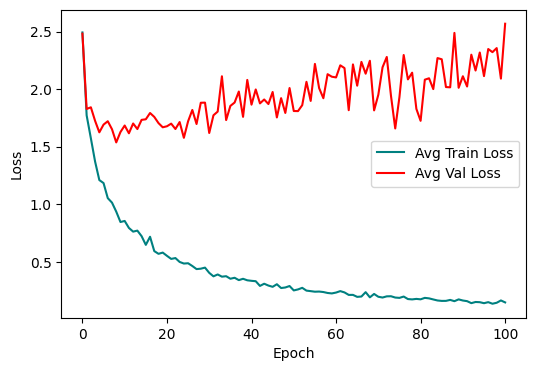

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(clear_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(clear_val_loss_list, color='red', label='Avg Val Loss')
#plt.title(f'Loss for AlexNet trained on Toybox (category-level) with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

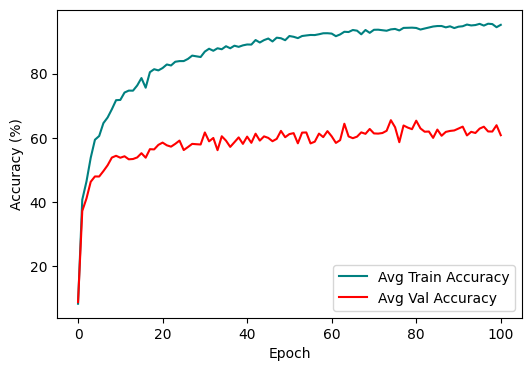

In [4]:
plt.figure(figsize=(6, 4))
plt.plot(clear_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(clear_val_correct, color='red', label='Avg Val Accuracy')
#plt.title(f'Accuracy for AlexNet trained on Toybox (category-level) with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Plot blurry-to-clear loss and accuracy

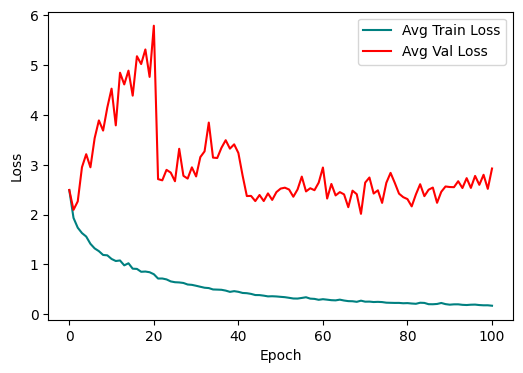

In [5]:
plt.figure(figsize=(6, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
#plt.title(f'Loss for AlexNet trained on Toybox (category-level) Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

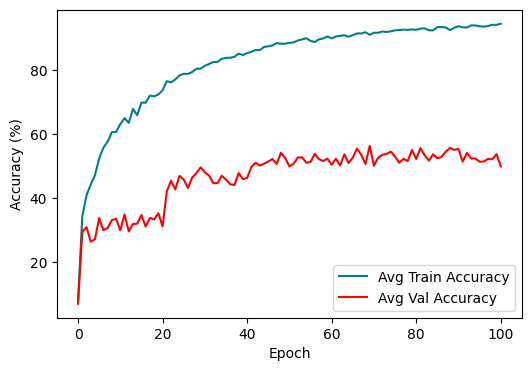

In [6]:
plt.figure(figsize=(6, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Val Accuracy')
#plt.title(f'Accuracy for AlexNet trained on Toybox (category-level) Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Full blur training

In [1]:
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
 

In [12]:
import torch
import torch.nn as nn
from model import AlexNetSup

epochs = 100
batch_size = 256
learning_rate = 0.001
output_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/toybox12_full_blur_2"

os.makedirs(output_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

blur_model = AlexNetSup(num_classes=12).to(device)

criterion = nn.CrossEntropyLoss()
blur_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, weight_decay=0.0001)
steps = len(train_loader)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(blur_optimizer, T_max=steps*epochs)

#blur_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=blur_optimizer, start_factor=0.01, end_factor=1.0,
#                                                      total_iters=2*steps)
#blur_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=blur_optimizer, T_max=(epochs - 2) * steps)
#blur_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=blur_optimizer,
#                                                            schedulers=[blur_warmup_scheduler, blur_decay_scheduler],
#                                                            milestones=[2*steps+1])

In [13]:
from utils import add_blur_with

# Initialize metrics for plotting
blur_train_correct, blur_val_correct = [], []
blur_train_loss_list, blur_val_loss_list = [], []
logs = []

blur_model.eval()

# Training metrics initialization
blur_train_corr, total_train = 0, 0
blur_train_loss = 0.0

with torch.no_grad():
    for _, images, labels in train_loader:
        # Apply blur transformation
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        blur_y_pred = blur_model(images)

        # Calculate loss values
        blur_loss = criterion(blur_y_pred, labels)

        # Accumulate total loss weighted by batch size
        blur_train_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        blur_predicted = torch.max(blur_y_pred.data, 1)[1]
        blur_train_corr += (blur_predicted == labels).sum().item()
        total_train += labels.size(0)

# Average accuracy and loss over all training samples
blur_train_accuracy = (blur_train_corr / total_train) * 100
blur_train_loss /= total_train

# Validation metrics initialization
blur_val_corr, total_val = 0, 0
blur_val_loss = 0.0

with torch.no_grad():
    for _, images, labels in val_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        # Get predictions from both models on validation data
        blur_y_val_pred = blur_model(images)

        # Calculate loss values for validation set
        blur_loss = criterion(blur_y_val_pred, labels)

        # Accumulate total loss weighted by batch size
        blur_val_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        blur_predicted = torch.max(blur_y_val_pred.data, 1)[1]
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

# Average accuracy and loss over all validation samples
blur_val_accuracy = (blur_val_corr / total_val) * 100
blur_val_loss /= total_val

# Save results for plotting
blur_train_correct.append(blur_train_accuracy)
blur_val_correct.append(blur_val_accuracy)
blur_train_loss_list.append(blur_train_loss)
blur_val_loss_list.append(blur_val_loss)

blur_log_entry = (f"Epoch 0/{epochs}, Train acc: {blur_train_accuracy:.4f}%, Train loss: {blur_train_loss:.4f}, Val acc: {blur_val_accuracy:.2f}%, Val loss: {blur_val_loss:.4f}")
print(blur_log_entry)
logs.append(blur_log_entry)

Epoch 0/100, Train acc: 8.2506%, Train loss: 2.4856, Val acc: 8.92%, Val loss: 2.4866


### Training loop

In [ ]:
import re
import os
import torch
from utils import add_blur_with

text = """
Epoch 0/50, Train acc: 8.2701%, Train loss: 2.4888, Val acc: 7.14%, Val loss: 2.4879
Epoch 1/50, Train acc: 35.5078%, Train loss: 1.9025, Val acc: 37.29%, Val loss: 1.9026
Epoch 2/50, Train acc: 44.0374%, Train loss: 1.6475, Val acc: 37.62%, Val loss: 1.8404
Epoch 3/50, Train acc: 49.4727%, Train loss: 1.4871, Val acc: 42.39%, Val loss: 1.8162
Epoch 4/50, Train acc: 54.7768%, Train loss: 1.3438, Val acc: 43.79%, Val loss: 1.7636
Epoch 5/50, Train acc: 57.6925%, Train loss: 1.2628, Val acc: 44.83%, Val loss: 1.7407
Epoch 6/50, Train acc: 60.8175%, Train loss: 1.1644, Val acc: 43.54%, Val loss: 1.9984
Epoch 7/50, Train acc: 63.2868%, Train loss: 1.0914, Val acc: 46.80%, Val loss: 1.7840
Epoch 8/50, Train acc: 65.5385%, Train loss: 1.0289, Val acc: 46.58%, Val loss: 1.8273
Epoch 9/50, Train acc: 66.9392%, Train loss: 0.9895, Val acc: 46.09%, Val loss: 1.9247
Epoch 10/50, Train acc: 68.4403%, Train loss: 0.9452, Val acc: 48.45%, Val loss: 1.7302
Epoch 11/50, Train acc: 69.3890%, Train loss: 0.9191, Val acc: 48.02%, Val loss: 1.8039
Epoch 12/50, Train acc: 71.3337%, Train loss: 0.8633, Val acc: 49.06%, Val loss: 1.7478
Epoch 13/50, Train acc: 72.2042%, Train loss: 0.8297, Val acc: 50.67%, Val loss: 1.8158
Epoch 14/50, Train acc: 72.9911%, Train loss: 0.8092, Val acc: 50.98%, Val loss: 1.8056
Epoch 15/50, Train acc: 73.1836%, Train loss: 0.8010, Val acc: 47.69%, Val loss: 1.9059
Epoch 16/50, Train acc: 74.4085%, Train loss: 0.7617, Val acc: 50.30%, Val loss: 1.9276
Epoch 17/50, Train acc: 75.9431%, Train loss: 0.7240, Val acc: 49.82%, Val loss: 1.8266
Epoch 18/50, Train acc: 75.2874%, Train loss: 0.7445, Val acc: 47.75%, Val loss: 1.9578
Epoch 19/50, Train acc: 76.6936%, Train loss: 0.6959, Val acc: 49.92%, Val loss: 1.8138
Epoch 20/50, Train acc: 76.3644%, Train loss: 0.7058, Val acc: 48.16%, Val loss: 1.8950
Epoch 21/50, Train acc: 78.1055%, Train loss: 0.6566, Val acc: 47.30%, Val loss: 2.0030
Epoch 22/50, Train acc: 79.2243%, Train loss: 0.6248, Val acc: 50.88%, Val loss: 2.0132
Epoch 23/50, Train acc: 80.2400%, Train loss: 0.5946, Val acc: 49.12%, Val loss: 2.0492
Epoch 24/50, Train acc: 79.8577%, Train loss: 0.6053, Val acc: 50.85%, Val loss: 1.9115
Epoch 25/50, Train acc: 80.2595%, Train loss: 0.5912, Val acc: 46.91%, Val loss: 2.0789
Epoch 26/50, Train acc: 80.9654%, Train loss: 0.5646, Val acc: 48.75%, Val loss: 2.0184
Epoch 27/50, Train acc: 81.8025%, Train loss: 0.5494, Val acc: 49.29%, Val loss: 2.1294
Epoch 28/50, Train acc: 82.1931%, Train loss: 0.5337, Val acc: 50.43%, Val loss: 2.0183
Epoch 29/50, Train acc: 82.8292%, Train loss: 0.5191, Val acc: 49.59%, Val loss: 2.1326
Epoch 30/50, Train acc: 82.7260%, Train loss: 0.5128, Val acc: 51.62%, Val loss: 1.9939
Epoch 31/50, Train acc: 83.2757%, Train loss: 0.5015, Val acc: 50.54%, Val loss: 1.9545
Epoch 32/50, Train acc: 83.7584%, Train loss: 0.4951, Val acc: 49.30%, Val loss: 2.2383
Epoch 33/50, Train acc: 83.8030%, Train loss: 0.4884, Val acc: 50.12%, Val loss: 2.0003
Epoch 34/50, Train acc: 83.9816%, Train loss: 0.4831, Val acc: 49.70%, Val loss: 2.2609
Epoch 35/50, Train acc: 85.0251%, Train loss: 0.4525, Val acc: 52.47%, Val loss: 1.9876
Epoch 36/50, Train acc: 85.4604%, Train loss: 0.4356, Val acc: 49.87%, Val loss: 2.1251
Epoch 37/50, Train acc: 85.7533%, Train loss: 0.4299, Val acc: 50.67%, Val loss: 2.1122
Epoch 38/50, Train acc: 86.2305%, Train loss: 0.4215, Val acc: 51.18%, Val loss: 2.0723
Epoch 39/50, Train acc: 86.1412%, Train loss: 0.4162, Val acc: 49.49%, Val loss: 2.1481
Epoch 40/50, Train acc: 86.4593%, Train loss: 0.4145, Val acc: 50.51%, Val loss: 2.0675
Epoch 41/50, Train acc: 86.4900%, Train loss: 0.4141, Val acc: 49.61%, Val loss: 2.2307
Epoch 42/50, Train acc: 86.2695%, Train loss: 0.4122, Val acc: 50.57%, Val loss: 2.1981
Epoch 43/50, Train acc: 86.7606%, Train loss: 0.4006, Val acc: 50.45%, Val loss: 2.2122
Epoch 44/50, Train acc: 86.5792%, Train loss: 0.4061, Val acc: 50.70%, Val loss: 2.1922
Epoch 45/50, Train acc: 87.0787%, Train loss: 0.3878, Val acc: 50.81%, Val loss: 2.1827
Epoch 46/50, Train acc: 87.0257%, Train loss: 0.3921, Val acc: 51.08%, Val loss: 2.2312
Epoch 47/50, Train acc: 87.1261%, Train loss: 0.3849, Val acc: 50.93%, Val loss: 2.1901
Epoch 48/50, Train acc: 87.1735%, Train loss: 0.3892, Val acc: 51.12%, Val loss: 2.1835
Epoch 49/50, Train acc: 87.0173%, Train loss: 0.3886, Val acc: 51.06%, Val loss: 2.1925
Epoch 50/50, Train acc: 87.4860%, Train loss: 0.3793, Val acc: 51.10%, Val loss: 2.1899
"""

pattern_blur = r"Train acc: ([\d.]+)%, Train loss: ([\d.]+), Val acc: ([\d.]+)%, Val loss: ([\d.]+)"
blur_data = re.findall(pattern_blur, text)

blur_train_correct = [float(acc) for acc, _, _, _ in blur_data]
blur_train_loss_list = [float(loss) for _, loss, _, _ in blur_data]
blur_val_correct = [float(val_acc) for _, _, val_acc, _ in blur_data]
blur_val_loss_list = [float(val_loss) for _, _, _, val_loss in blur_data]

# Split the text into individual lines
logs = text.strip().split("\n")

resume_epoch = 50
blur_checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{resume_epoch}.pth')

if os.path.exists(blur_checkpoint_path):
    print(f"Loading checkpoint from epoch {resume_epoch}...")
    blur_checkpoint = torch.load(blur_checkpoint_path, map_location=device)

    # Load model and optimizer states
    blur_model.load_state_dict(blur_checkpoint['model_state_dict'])
    blur_optimizer.load_state_dict(blur_checkpoint['optimizer_state_dict'])

    # Update starting epoch from the checkpoint
    start_epoch = blur_checkpoint.get('epoch', resume_epoch)
    print(f"Successfully resumed training from epoch {start_epoch}.")
else:
    print("Checkpoint not found, starting from scratch.")
    start_epoch = 0

# Set model to evaluation mode to verify weights are loaded correctly
blur_model.eval()

# Run a quick validation check
blur_val_corr, total_val = 0, 0
with torch.no_grad():
    for _, images, labels in val_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)
        blur_pred = blur_model(images)
        blur_predicted = torch.max(blur_pred, 1)[1]
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

blur_val_acc = (blur_val_corr / total_val) * 100
print(f"Validation Accuracy after checkpoint load - Blur Model: {blur_val_acc:.2f}%")

Loading checkpoint from epoch 50...
Successfully resumed training from epoch 50.
Validation Accuracy after checkpoint load - Blur Model: 51.10%


In [17]:
output_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/toybox12_full_blur_2"

for epoch in range(10, epochs):

    ###################### Train model #########################
    blur_model.train()
    # Initialize accumulators for training loss and sample count
    blur_train_loss_sum = 0.0
    train_samples = 0

    for _, images, labels in train_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        blur_optimizer.zero_grad()

        # Forward passes
        blur_logits = blur_model(images)

        # Compute losses
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        blur_loss.backward()
        blur_optimizer.step()
        scheduler.step()
        #blur_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    blur_model.eval()
    blur_train_corr, total_train = 0, 0
    blur_train_loss_eval = 0.0

    with torch.no_grad():
        for _, images, labels in train_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Calculate loss on the training set (evaluation mode)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    blur_train_accuracy = (blur_train_corr / total_train) * 100
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    blur_val_corr, total_val = 0, 0
    blur_val_loss_sum = 0.0

    with torch.no_grad():
        for _, images, labels in val_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Compute validation losses
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    blur_val_accuracy = (blur_val_corr / total_val) * 100
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    blur_train_loss_list.append(blur_train_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Train acc: {blur_train_accuracy:.4f}%, Train loss: {blur_train_loss_avg:.4f}, Val acc: {blur_val_accuracy:.2f}%, Val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        blur_checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 11/100, Train acc: 68.3259%, Train loss: 0.9461, Val acc: 45.41%, Val loss: 1.8226
Epoch 12/100, Train acc: 71.2026%, Train loss: 0.8724, Val acc: 46.84%, Val loss: 2.0083
Epoch 13/100, Train acc: 71.7746%, Train loss: 0.8494, Val acc: 43.96%, Val loss: 2.1136
Epoch 14/100, Train acc: 72.1094%, Train loss: 0.8337, Val acc: 46.93%, Val loss: 1.9302
Epoch 15/100, Train acc: 73.7695%, Train loss: 0.7920, Val acc: 47.14%, Val loss: 2.0699
Epoch 16/100, Train acc: 75.5469%, Train loss: 0.7284, Val acc: 48.08%, Val loss: 2.1092
Epoch 17/100, Train acc: 74.6317%, Train loss: 0.7555, Val acc: 48.84%, Val loss: 1.9005
Epoch 18/100, Train acc: 76.6462%, Train loss: 0.6993, Val acc: 48.12%, Val loss: 1.9282
Epoch 19/100, Train acc: 76.8415%, Train loss: 0.6934, Val acc: 47.87%, Val loss: 1.9808
Epoch 20/100, Train acc: 75.9626%, Train loss: 0.7213, Val acc: 46.25%, Val loss: 2.1003
Epoch 21/100, Train acc: 77.6869%, Train loss: 0.6727, Val acc: 46.35%, Val loss: 2.1212
Epoch 22/100, Train a

In [15]:
os.makedirs(output_dir, exist_ok=True)

In [16]:
epoch = 9

blur_checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{epoch+1}.pth')
checkpoint_blur = {
    'epoch': epoch+1,
    'model_state_dict': blur_model.state_dict(),
    'optimizer_state_dict': blur_optimizer.state_dict(),
    'train_accuracy': blur_train_accuracy,
    'train_loss': blur_train_loss_epoch,
}
torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 1/100, Train acc: 34.4280%, Train loss: 1.9396, Val acc: 31.45%, Val loss: 2.0773
Epoch 2/100, Train acc: 42.6674%, Train loss: 1.7152, Val acc: 39.05%, Val loss: 1.9303
Epoch 3/100, Train acc: 49.0374%, Train loss: 1.4988, Val acc: 39.91%, Val loss: 2.0373
Epoch 4/100, Train acc: 52.9548%, Train loss: 1.3880, Val acc: 39.89%, Val loss: 1.8918
Epoch 5/100, Train acc: 58.1585%, Train loss: 1.2511, Val acc: 41.31%, Val loss: 1.8053
Epoch 6/100, Train acc: 60.9849%, Train loss: 1.1590, Val acc: 45.76%, Val loss: 1.7456
Epoch 7/100, Train acc: 63.9872%, Train loss: 1.0751, Val acc: 45.68%, Val loss: 1.9268
Epoch 8/100, Train acc: 65.0642%, Train loss: 1.0429, Val acc: 45.29%, Val loss: 1.9098
Epoch 9/100, Train acc: 66.6825%, Train loss: 1.0065, Val acc: 45.27%, Val loss: 1.8293
Epoch 10/100, Train acc: 68.9258%, Train loss: 0.9272, Val acc: 47.27%, Val loss: 1.7827

### Save logs to a txt file

In [18]:
import pickle

with open(f"{output_dir}/training_log.txt", 'w') as log_file:
    for log_entry in logs:
        log_file.write(log_entry + '\n')

blur_metrics = {
    'blur_train_correct': blur_train_correct,
    'blur_val_correct': blur_val_correct,
    'blur_train_loss_list': blur_train_loss_list,
    'blur_val_loss_list': blur_val_loss_list
}

with open(f"{output_dir}/metrics.pkl", "wb") as metrics_file:
    pickle.dump(blur_metrics, metrics_file)

### Plot loss and accuracy

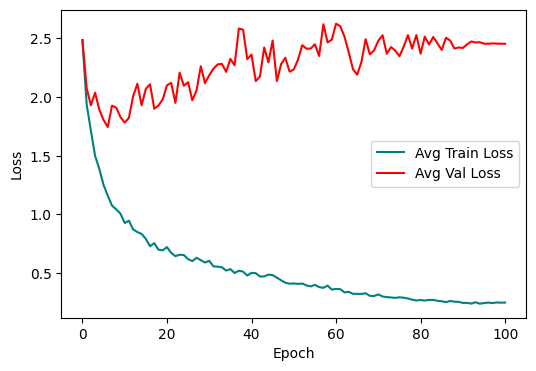

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
#plt.title(f'Loss for AlexNet trained on Blurry Toybox (Category-level) Dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

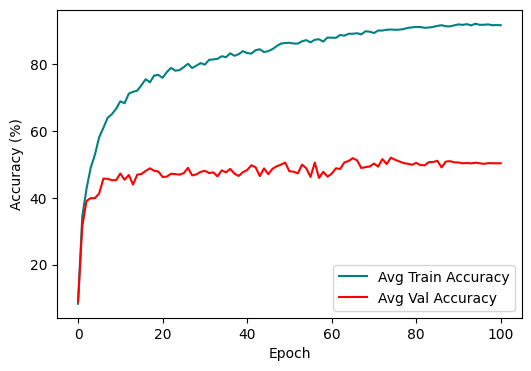

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Val Accuracy')
#plt.title(f'Accuracy for AlexNet trained on Toybox (Category-level) Dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()